# Rainbow Trout Meat Quality Classification using Genomic Data 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import json
from tqdm import tqdm

from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

SEED = 32
%autosave 30

Autosaving every 30 seconds


In [2]:
import gc

import warnings
warnings.filterwarnings("ignore")

## Meta Data Creation

In [4]:
# %%time
# metadf_init = pd.read_excel("./data/GeneExpressionData/Meta_data.xlsx", usecols=['genetic line','Orso_Id'])
# print(f"Initial Dataframe Size:{metadf_init.shape}")

# #Dropping rows with NaN values.
# metadf_init.dropna(inplace=True)
# print(f"Dataframe Size post cleaning:{metadf_init.shape}")
# metadf_init.head()

In [5]:
# def processRows(row):
#     geneLine, fishId = row['genetic line'].split('-')[-1], row['Orso_Id'].split('_')[-1]
#     # print(geneLine, fishId)
#     return pd.Series(data = [f"F{fishId}", 'high' if geneLine=='H' else 'low'], index=['FishID', 'GeneLine'])

# metadf_init.apply(processRows, axis=1).to_csv("./metaFishData.csv", index=False)

## Meta Data

In [6]:
metadf = pd.read_csv("./metaFishData.csv")
metadf.head()

,FishID,GeneLine
0,F75,high
1,F66,low
2,F76,high
3,F72,low
4,F78,high


In [7]:
metadf['GeneLine'].value_counts(normalize=True)

GeneLine
high    0.504298
low     0.495702
Name: proportion, dtype: float64

## PathAbundance CPM Profile

In [248]:
# %%time
# mp_df = pd.read_csv("./data/GeneExpressionData/merged_metaphlan_profile.tsv", sep='\t', header=0).reset_index()
# print(f"Metaphlan Profile Data Shape: {mp_df.shape}")

# #Generating consistent Fish Identification Marking
# fishIdentifierFnx = lambda row: f'F{row.split("_")[3]}'
# mp_df.iloc[0, 1:] = mp_df.iloc[0, 1:].apply(fishIdentifierFnx)

# #Setting Column Names to the fish identification markings
# mp_df.columns = mp_df.iloc[0]
# mp_df.drop(mp_df.index[0], inplace=True)
# mp_df.head()

In [249]:
%%time
mp_df = pd.read_csv("./data/GeneExpressionData/humann_pathabundance_merged_cpm.tsv", sep='\t', header=0)#.reset_index(drop=True)
print(f"Path Abundance CPM Profile Data Shape: {mp_df.shape}")

#Generating consistent Fish Identification Marking
fishIdentifierFnx = lambda row: f'F{row.split("_")[3]}'

colNames = list(map(fishIdentifierFnx, mp_df.columns[1:]))
colNames.insert(0, 'clade_name')

mp_df.columns = colNames
mp_df.head()

Path Abundance CPM Profile Data Shape: (6835, 352)
CPU times: user 85.6 ms, sys: 17.5 ms, total: 103 ms
Wall time: 103 ms


,clade_name,F100,F101,F102,F103,F104,F105,F106,F107,F108,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F9
0,UNMAPPED,913783.0,804474.0,882094.0,799929.0,812526.0,734514.0,711594.0,646577.0,930722.0,...,783320.0,899060.0,895572.0,662809.0,962781.0,985565.0,810644.0,962823.0,997729.00,838469.0
1,UNINTEGRATED,47444.9,181615.0,54773.9,167266.0,139233.0,217285.0,264653.0,308450.0,35426.2,...,173189.0,49811.1,53371.9,289614.0,21325.5,14068.4,170383.0,23586.1,1794.43,126577.0
2,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,UNINTEGRATED|g__Aeromonas.s__Aeromonas_bestiarum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [250]:
print(mp_df.iloc[3,0])

delimiters = r"[.|_]"
# delimiters = r"([|.])|(_)"
result = re.split(delimiters, mp_df.iloc[97,0])
# result = [s.replace('__', '__ ', 1) for s in result]
result

UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_johnsonii


['UNINTEGRATED', 'g', '', 'Oceanobacillus', 's', '', 'Oceanobacillus', 'caeni']

## Clade Family

In [251]:
from treelib import Node, Tree
import re

In [252]:
def cladeFnxLambda(row):
    result = re.split(delimiters, row)
    result = [i for i in result if len(i)>1]
    return len(result)
    
clade.apply(cladeFnxLambda).value_counts()

clade_name
4    5345
1     539
2     539
5     305
6      96
3      11
Name: count, dtype: int64

In [253]:
# %%time
# tree = Tree()
# tree.create_node('Main', 'main')
# def cladeFnxTree(row):
#     row = row.split('|')
#     if len(row)==1:
#         tree.create_node(row[0], row[0], parent='main')
#     else:
#         tree.create_node(row[-1], row[-1], parent=row[-2])
             
# _ = clade.apply(cladeFnxTree)

# print("Depth of tree:", tree.depth())
# tree.show()      

In [254]:
# treeFamily = json.loads(tree.to_json(with_data=False))

In [255]:
# clade.apply(cladeFnxLambda)

In [256]:
familyMap = {f'level{r}':[] for r in range(0,6)}

def cladeFnx(row):
    row_ = re.split(delimiters, row)
    row_ = [i for i in row_ if len(i)>1]
    # print(len(row_))
    familyMap[f'level{len(row_)-1}'].append(row)
    

_ = clade.apply(cladeFnx)

In [257]:
familyMap.keys()
# familyMap['level5']

dict_keys(['level0', 'level1', 'level2', 'level3', 'level4', 'level5'])

In [258]:
for i in familyMap:
    familyMap[i] = list(set(familyMap[i]))

familyMapRev = {}
for i in familyMap:
    for j in familyMap[i]:
        familyMapRev[j] = i

In [259]:
# familyMapRev

## Initial Exploration

In [260]:
mp_fin = mp_df.set_index('clade_name').T
mp_fin = mp_fin.apply(pd.to_numeric, downcast='float')

mp_fin = pd.merge(left=mp_fin, right=metadf, left_index=True, right_on='FishID', how='inner').drop('FishID', axis=1)
mp_fin.dropna(inplace=True)
print(mp_fin.shape)

(349, 6836)


In [261]:
# mp_fin.to_csv("./data/pathAbundanceCPMData.csv", index=False)

In [262]:
mp_fin.head()

,UNMAPPED,UNINTEGRATED,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_albensis,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_johnsonii,UNINTEGRATED|g__Aeromonas.s__Aeromonas_bestiarum,UNINTEGRATED|g__Aeromonas.s__Aeromonas_diversa,UNINTEGRATED|g__Aeromonas.s__Aeromonas_hydrophila,UNINTEGRATED|g__Aeromonas.s__Aeromonas_media,UNINTEGRATED|g__Aeromonas.s__Aeromonas_rivipollensis,UNINTEGRATED|g__Aeromonas.s__Aeromonas_sobria,...,VALSYN-PWY: L-valine biosynthesis|g__Staphylococcus.s__Staphylococcus_xylosus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_dysgalactiae_group,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_equinus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_gallolyticus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_infantarius,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_lutetiensis,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_macedonicus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_pasteurianus,VALSYN-PWY: L-valine biosynthesis|unclassified,GeneLine
181,913783.0,47444.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.730011,high
209,804474.0,181615.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.457899,high
246,882094.0,54773.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.724197,high
78,799929.0,167266.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.072006,high
265,812526.0,139233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.977100,high


### Outlier Analysis

In [263]:
mp_fin.iloc[:, :].shape

(349, 6836)

In [264]:
# Number of outliers in each column
def outliersFnx(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return len(data[s>m])

In [265]:
fnx = lambda row: type(row.values)
fnx = lambda row: outliersFnx(row.values)
outlierCount = mp_fin.iloc[:, :-1].apply(fnx, axis=0).values

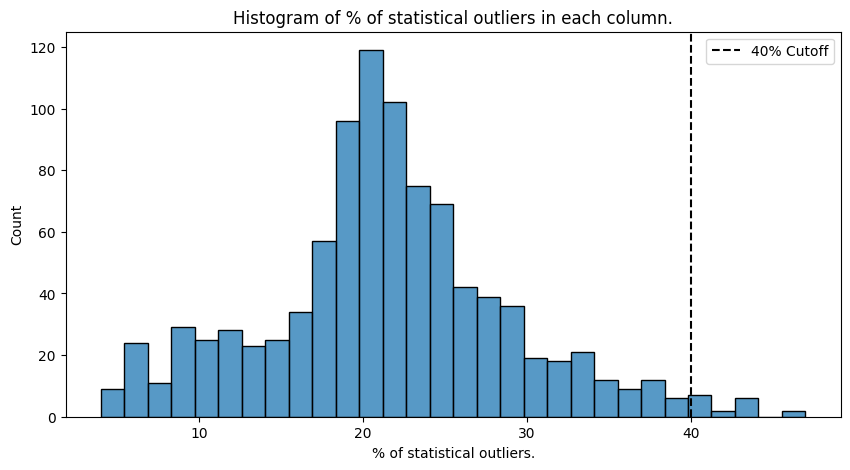

In [266]:
OUTLIER_CUTOFF = 40
plt.figure(figsize=(10,5), dpi = 100)
sns.histplot(data=outlierCount[outlierCount!=0]*100/(mp_df.shape[1]-1), bins=30)
plt.axvline(x=OUTLIER_CUTOFF, color='black', linestyle='--', label='40% Cutoff')
plt.legend()
plt.title("Histogram of % of statistical outliers in each column.")
plt.xlabel("% of statistical outliers.")
plt.show()

The dashed vertical lines represents the cutoff mark, beyond which there are features with more than the cutoff statistical outlier values.

In [197]:
var_ = outlierCount*100/(mp_df.shape[1]-1)
len(var_[var_>40])

print(f"{len(var_[var_>40])} out of {len(var_)} features have more than {OUTLIER_CUTOFF}% datapoints as statistical outliers.")

15 out of 6835 features have more than 40% datapoints as statistical outliers.


In [267]:
hmap = {'feature':[], 'outlierCount':[], 'outlierCount%':[], 'level':[]}
for i,j  in zip(mp_fin.columns, outlierCount):
    hmap['feature'].append(i)
    hmap['outlierCount'].append(j)
    hmap['outlierCount%'].append(j*100/mp_df.shape[1])
    hmap['level'].append(cladeFnxLambda(i))
    
outlierDf = pd.DataFrame(hmap)

In [274]:
len(hmap['feature'])
len(outlierCount)

6835

In [275]:
len(mp_fin.columns)

6836

In [276]:
outlierDf.shape

(6835, 4)

In [277]:
outlierDf[outlierDf['outlierCount%']>OUTLIER_CUTOFF].head()

,feature,outlierCount,outlierCount%,level
733,FAO-PWY: fatty acid &beta;-oxidation I (generic),152,43.181818,1
1397,ORNDEG-PWY: superpathway of ornithine degradation,161,45.738636,1
1763,PWY-1269: CMP-3-deoxy-D-manno-octulosonate bio...,142,40.340909,1
1791,PWY-1861: formaldehyde assimilation II (assimi...,143,40.625000,5
1871,PWY-3841: folate transformations II (plants)|g...,152,43.181818,4


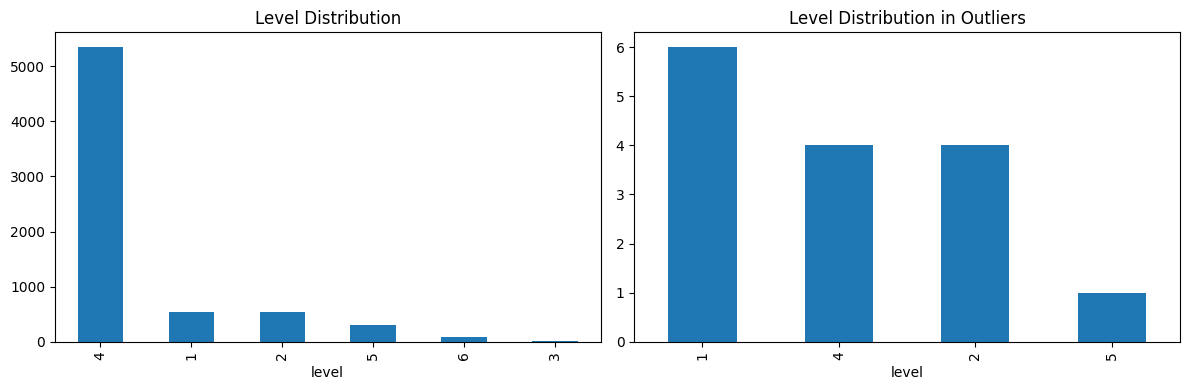

In [278]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
outlierDf['level'].value_counts().plot(kind='bar', ax=ax[0])
outlierDf[outlierDf['outlierCount%']>OUTLIER_CUTOFF]['level'].value_counts().plot(kind='bar', ax=ax[1])

ax[0].set_title('Level Distribution')
ax[1].set_title('Level Distribution in Outliers')
plt.tight_layout()
plt.show()

In [279]:
# Variance
mp_fin.groupby('GeneLine').var()

,UNMAPPED,UNINTEGRATED,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_albensis,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_johnsonii,UNINTEGRATED|g__Aeromonas.s__Aeromonas_bestiarum,UNINTEGRATED|g__Aeromonas.s__Aeromonas_diversa,UNINTEGRATED|g__Aeromonas.s__Aeromonas_hydrophila,UNINTEGRATED|g__Aeromonas.s__Aeromonas_media,UNINTEGRATED|g__Aeromonas.s__Aeromonas_rivipollensis,UNINTEGRATED|g__Aeromonas.s__Aeromonas_sobria,...,VALSYN-PWY: L-valine biosynthesis|g__Staphylococcus.s__Staphylococcus_simulans,VALSYN-PWY: L-valine biosynthesis|g__Staphylococcus.s__Staphylococcus_xylosus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_dysgalactiae_group,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_equinus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_gallolyticus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_infantarius,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_lutetiensis,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_macedonicus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_pasteurianus,VALSYN-PWY: L-valine biosynthesis|unclassified
GeneLine,,,,,,,,,,,,,,,,,,,,,
high,2.051422e+10,1.561710e+10,330.794861,1975.280396,9.780278e+04,3.880166e+05,5.477877e+04,1611.636108,1.751288e+03,8.620087e+07,...,0.000000,0.000358,0.040123,0.001204,0.003983,0.002853,0.003263,0.000938,0.000572,11198.749023
low,3.319654e+10,1.800541e+10,0.000000,0.000000,1.168652e+07,1.156839e+07,1.019728e+06,94357.296875,1.119131e+06,3.413406e+06,...,0.000167,0.001052,0.037866,0.000712,0.001531,0.004253,0.002518,0.000681,0.000184,3353.336426


In [280]:
LEVEL = 'level2'
temp_ = mp_fin.loc[:, familyMap[LEVEL]+['GeneLine']].groupby('GeneLine').mean().T
temp_ = temp_[temp_['high']<30]
temp_.head()

GeneLine,high,low
PWY-6285: superpathway of fatty acids biosynthesis (E. coli)|unclassified,11.339546,9.198452
PWY-7820: teichuronic acid biosynthesis (B. subtilis 168)|unclassified,0.130105,0.000000
FASYN-INITIAL-PWY: superpathway of fatty acid biosynthesis initiation (E. coli)|unclassified,1.233978,1.405536
POLYISOPRENSYN-PWY: polyisoprenoid biosynthesis (E. coli)|unclassified,18.416389,16.014008
PWY0-166: superpathway of pyrimidine deoxyribonucleotides de novo biosynthesis (E. coli)|unclassified,9.323432,7.964573


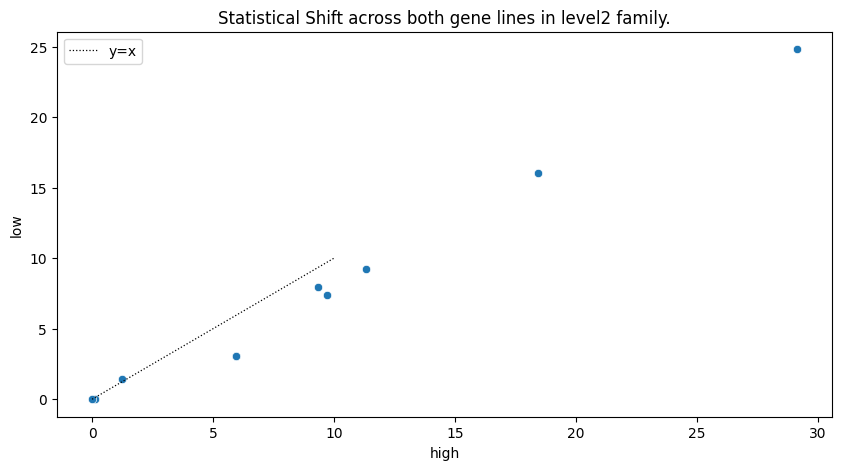

In [281]:
t_ = 10

plt.figure(figsize=(10, 5), dpi = 100)
sns.scatterplot(x=temp_['high'], y=temp_['low'])
plt.plot([0,t_], [0, t_], ls=':', color='black', linewidth = .9, label='y=x')
plt.title(f"Statistical Shift across both gene lines in {LEVEL} family.")
plt.legend()
plt.show()

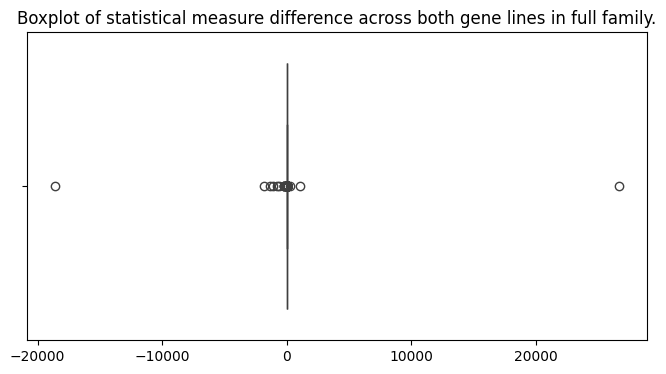

In [282]:
LEVEL = 'full'
temp2_ = mp_fin.groupby('GeneLine').median().T
temp2Diff_ = (temp2_['high']-temp2_['low'])

plt.figure(figsize=(8, 4), dpi = 100)
sns.boxplot(data=temp2Diff_, showfliers=True, orient = 'h')

plt.title(f"Boxplot of statistical measure difference across both gene lines in {LEVEL} family.")
plt.show()

We see that several features are present in the outlier region

In [283]:
# temp2_ = mp_fin.groupby('GeneLine').mean().T
# temp2_ = mp_fin.groupby('GeneLine').median().T
# temp2_ = mp_fin.groupby('GeneLine').var().T
# temp2Diff_ = (temp2_['high']-temp2_['low'])

# outlierDf = pd.merge(left=outlierDf, right = temp2Diff_.rename("statVarDiff"), left_on='feature', right_index=True)

### Mutual Importance

In [284]:
from sklearn.feature_selection import mutual_info_classif

In [285]:
%%time
# Mutual Information
mi = mutual_info_classif(mp_fin.iloc[:, :-1], mp_fin.iloc[:, -1].replace({'high':1, 'low':0}))

CPU times: user 4.86 s, sys: 50.1 ms, total: 4.91 s
Wall time: 4.91 s


In [286]:
outlierDf = outlierDf.assign(mi=mi)

In [212]:
# outlierDf

In [213]:
# outlierDf[outlierDf['mi']!=0].sort_values('mi', ascending=False)

In [287]:
# outlierDf.to_csv("./metaFishOutlierDataPACPM.csv", index=False)

# Machine Learning

Data Creation

In [288]:
outlierDf = pd.read_csv("./metaFishOutlierDataPACPM.csv")
mp_df = pd.read_csv("./data/pathAbundanceCPMData.csv")

In [289]:
mp_df.head()

,UNMAPPED,UNINTEGRATED,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_albensis,UNINTEGRATED|g__Acinetobacter.s__Acinetobacter_johnsonii,UNINTEGRATED|g__Aeromonas.s__Aeromonas_bestiarum,UNINTEGRATED|g__Aeromonas.s__Aeromonas_diversa,UNINTEGRATED|g__Aeromonas.s__Aeromonas_hydrophila,UNINTEGRATED|g__Aeromonas.s__Aeromonas_media,UNINTEGRATED|g__Aeromonas.s__Aeromonas_rivipollensis,UNINTEGRATED|g__Aeromonas.s__Aeromonas_sobria,...,VALSYN-PWY: L-valine biosynthesis|g__Staphylococcus.s__Staphylococcus_xylosus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_dysgalactiae_group,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_equinus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_gallolyticus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_infantarius,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_lutetiensis,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_macedonicus,VALSYN-PWY: L-valine biosynthesis|g__Streptococcus.s__Streptococcus_pasteurianus,VALSYN-PWY: L-valine biosynthesis|unclassified,GeneLine
0,913783.0,47444.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.7300,high
1,804474.0,181615.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.4579,high
2,882094.0,54773.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.7242,high
3,799929.0,167266.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0720,high
4,812526.0,139233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.9771,high


In [290]:
def genDataFnx(columns='full', scale=None, test_size=0.3, stratify=False, SEED=SEED, data=mp_df):
    '''
    args
    data: input dataframe. default mp_df
    columns: columns to consider. default 'full'. inputs list.
    scale: scaling strategy. default None. inputs 'standard', 'minmax'.
    test_size: data split test size. defaults 0.3. inputs float, None (no train test split).
    stratify: stratify strategy. defaults False. On labels if True.
    SEED: random state SEED
    '''
    dataModel = mp_df.copy()
    dataModel.replace({'GeneLine':{'high':1, 'low':0}}, inplace=True)

    if columns == 'full':
        xdata, ydata = dataModel.iloc[:,:-1], dataModel.iloc[:,-1]
    else:
        xdata, ydata = dataModel.loc[:,columns], dataModel.iloc[:,-1]
    sca = None
    if scale=='standard':
        sca = StandardScaler()
        xdata = sca.fit_transform(xdata)
    elif scale=='minmax':
        sca = MinMaxScaler()
        xdata = sca.fit_transform(xdata)

    if test_size==None:
        return np.array(xdata), np.array(ydata)

    if stratify==False:
        xstrain, xstest, ytrain, ytest = train_test_split(xdata, ydata, test_size=test_size, random_state=SEED)
    else:
        xstrain, xstest, ytrain, ytest = train_test_split(xdata, ydata, test_size=test_size, stratify=ydata, random_state=SEED)
    
    xstrain, xstest = np.array(xstrain), np.array(xstest)
    del dataModel, xdata, ydata
    gc.collect()
    print(f"Data Shape: {xstrain.shape} : {xstest.shape} : {ytrain.shape} : {ytest.shape}")
    return xstrain, xstest, ytrain, ytest, sca

xtrain, xtest, ytrain, ytest, _ = genDataFnx()

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)


In [291]:
def resultAnalysisFnx(ytrue,ypred,target_names=None,plot=True):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    
    plt.figure(figsize=(4, 3))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

In [292]:
TARGETNAMES = ['low', 'high']

## Naive Bayes - Gaussian

In [293]:
from sklearn.naive_bayes import GaussianNB

In [294]:
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale=None)

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)


In [295]:
%%time
gnb = GaussianNB()
gnb.fit(xtrain, ytrain)

ypred = gnb.predict(xtest)

CPU times: user 11.3 ms, sys: 4.74 ms, total: 16.1 ms
Wall time: 15.2 ms


In [296]:
ytest.value_counts()

GeneLine
0    57
1    48
Name: count, dtype: int64

              precision    recall  f1-score   support

         low       0.57      0.95      0.71        57
        high       0.70      0.15      0.24        48

    accuracy                           0.58       105
   macro avg       0.63      0.55      0.48       105
weighted avg       0.63      0.58      0.50       105



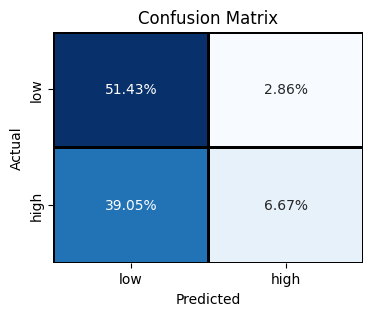

In [297]:
_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### KFold CV

In [298]:
xdata, ydata = genDataFnx(test_size=None)
gnbK = GaussianNB()

In [299]:
CV = 10
scores = cross_val_score(gnbK, xdata, ydata, cv=5, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.16% accuracy with a standard deviation of 0.05 for 10 folds.


### MI Fea Imp Columns

In [300]:
colExp = outlierDf[outlierDf['mi']!=0]['feature'].values.tolist()
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)

Data Shape: (244, 3359) : (105, 3359) : (244,) : (105,)


In [301]:
%%time
gnb = GaussianNB()
gnb.fit(xtrainE, ytrainE)

ypredE = gnb.predict(xtestE)

CPU times: user 13 ms, sys: 4.83 ms, total: 17.8 ms
Wall time: 15.6 ms


              precision    recall  f1-score   support

         low       0.56      0.96      0.71        57
        high       0.71      0.10      0.18        48

    accuracy                           0.57       105
   macro avg       0.64      0.53      0.45       105
weighted avg       0.63      0.57      0.47       105



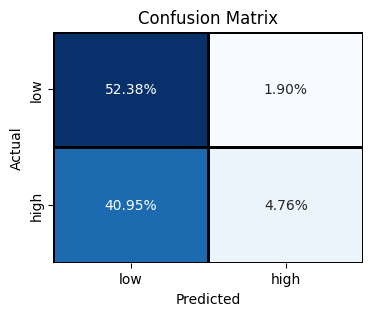

In [302]:
_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### NB - Level Wise

In [303]:
outlierDf['level'].value_counts()

level
4    5345
1     539
2     539
5     305
6      96
3      11
Name: count, dtype: int64

6

In [305]:
for i in range(1, outlierDf['level'].max()+1):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)
    gnb = GaussianNB()
    gnb.fit(xtrainE, ytrainE)
    
    ypredE = gnb.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    print(f"Number of Columns at level{i}: {len(colExp)} features with acc of {tt['accuracy']*100:.2f}%")

Data Shape: (244, 539) : (105, 539) : (244,) : (105,)
Number of Columns at level1: 539 features with acc of 54.29%
Data Shape: (244, 539) : (105, 539) : (244,) : (105,)
Number of Columns at level2: 539 features with acc of 44.76%
Data Shape: (244, 11) : (105, 11) : (244,) : (105,)
Number of Columns at level3: 11 features with acc of 56.19%
Data Shape: (244, 5345) : (105, 5345) : (244,) : (105,)
Number of Columns at level4: 5345 features with acc of 53.33%
Data Shape: (244, 305) : (105, 305) : (244,) : (105,)
Number of Columns at level5: 305 features with acc of 48.57%
Data Shape: (244, 96) : (105, 96) : (244,) : (105,)
Number of Columns at level6: 96 features with acc of 55.24%


## Logistic Regression

In [306]:
from sklearn.linear_model import LogisticRegression

In [307]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')
logres = LogisticRegression(random_state=SEED)

logres.fit(xtrain, ytrain)

ypred = logres.predict(xtest)

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)
CPU times: user 1.12 s, sys: 18.1 ms, total: 1.14 s
Wall time: 355 ms


              precision    recall  f1-score   support

         low       0.46      0.33      0.39        57
        high       0.41      0.54      0.46        48

    accuracy                           0.43       105
   macro avg       0.43      0.44      0.43       105
weighted avg       0.44      0.43      0.42       105



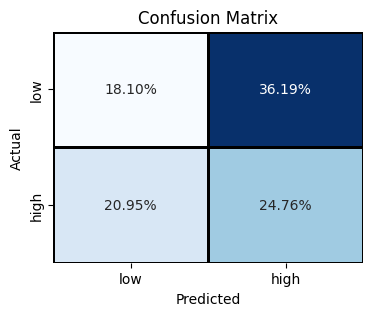

In [308]:
_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### Feature Importance

In [309]:
feature_importance = logres.coef_[0]

In [310]:
odf_temp = outlierDf.assign(logresFeaImp = feature_importance)

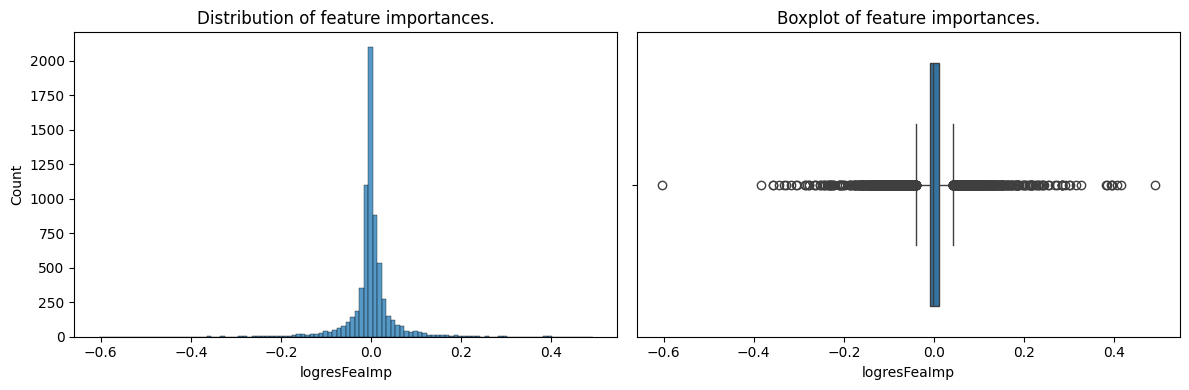

In [311]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
sns.histplot(data=odf_temp['logresFeaImp'], binwidth=0.01, ax=ax[0])
sns.boxplot(data=odf_temp['logresFeaImp'], orient='h', ax=ax[1])
ax[0].set_title('Distribution of feature importances.')
ax[1].set_title('Boxplot of feature importances.')
plt.tight_layout()
plt.show()

Data Shape: (244, 389) : (105, 389) : (244,) : (105,)
              precision    recall  f1-score   support

         low       0.61      0.40      0.48        57
        high       0.49      0.69      0.57        48

    accuracy                           0.53       105
   macro avg       0.55      0.55      0.53       105
weighted avg       0.55      0.53      0.53       105



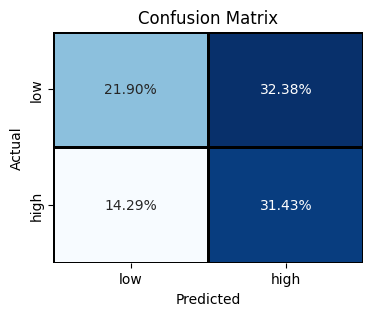

CPU times: user 511 ms, sys: 245 ms, total: 756 ms
Wall time: 234 ms


In [312]:
%%time
colExp = odf_temp[(odf_temp['logresFeaImp']<-0.1)|(odf_temp['logresFeaImp']>0.1)]['feature'].values.tolist()
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)

logres = LogisticRegression(random_state=SEED)
logres.fit(xtrainE, ytrainE)

ypredE = logres.predict(xtestE)

_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### KFold CV

In [313]:
xdata, ydata = genDataFnx(scale='standard', test_size=None)

logresK = LogisticRegression(random_state=SEED)

CV = 10
scores = cross_val_score(logresK, xdata, ydata, cv=5, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.49% accuracy with a standard deviation of 0.05 for 10 folds.


### MI Fea Imp Columns

Data Shape: (244, 3359) : (105, 3359) : (244,) : (105,)
              precision    recall  f1-score   support

         low       0.57      0.30      0.39        57
        high       0.47      0.73      0.57        48

    accuracy                           0.50       105
   macro avg       0.52      0.51      0.48       105
weighted avg       0.52      0.50      0.47       105



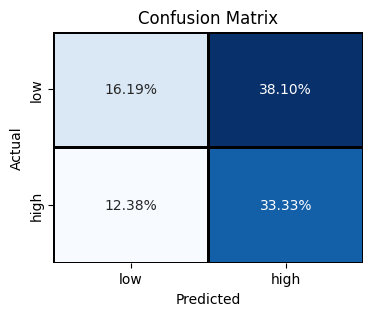

CPU times: user 906 ms, sys: 49.6 ms, total: 955 ms
Wall time: 295 ms


In [314]:
%%time
colExp = outlierDf[outlierDf['mi']!=0]['feature'].values.tolist()
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale=None)

logres = LogisticRegression(random_state=SEED)
logres.fit(xtrainE, ytrainE)

ypredE = logres.predict(xtestE)

_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### LogRes - Level Wise

In [316]:
for i in range(1, max(outlierDf['level'])+1):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale='standard')
    
    logres = LogisticRegression(random_state=SEED)
    logres.fit(xtrainE, ytrainE)
    
    ypredE = logres.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    print(f"Number of Columns at level{i}: {len(colExp)} features with acc of {tt['accuracy']*100:.2f}%")

Data Shape: (244, 539) : (105, 539) : (244,) : (105,)
Number of Columns at level1: 539 features with acc of 47.62%
Data Shape: (244, 539) : (105, 539) : (244,) : (105,)
Number of Columns at level2: 539 features with acc of 49.52%
Data Shape: (244, 11) : (105, 11) : (244,) : (105,)
Number of Columns at level3: 11 features with acc of 42.86%
Data Shape: (244, 5345) : (105, 5345) : (244,) : (105,)
Number of Columns at level4: 5345 features with acc of 43.81%
Data Shape: (244, 305) : (105, 305) : (244,) : (105,)
Number of Columns at level5: 305 features with acc of 44.76%
Data Shape: (244, 96) : (105, 96) : (244,) : (105,)
Number of Columns at level6: 96 features with acc of 46.67%


Data Shape: (244, 5345) : (105, 5345) : (244,) : (105,)
              precision    recall  f1-score   support

         low       0.48      0.49      0.49        57
        high       0.38      0.38      0.38        48

    accuracy                           0.44       105
   macro avg       0.43      0.43      0.43       105
weighted avg       0.44      0.44      0.44       105



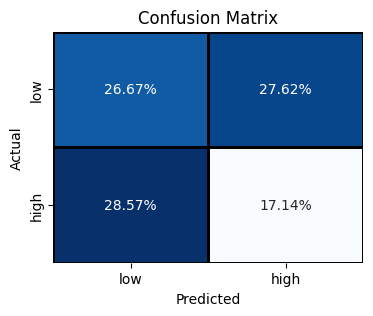

In [318]:
colExp = outlierDf[outlierDf['level']==4]['feature'].values.tolist()   
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale='standard')

logres = LogisticRegression(random_state=SEED)
logres.fit(xtrainE, ytrainE)

ypredE = logres.predict(xtestE)
_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

In [319]:
feature_importance = logres.coef_[0]

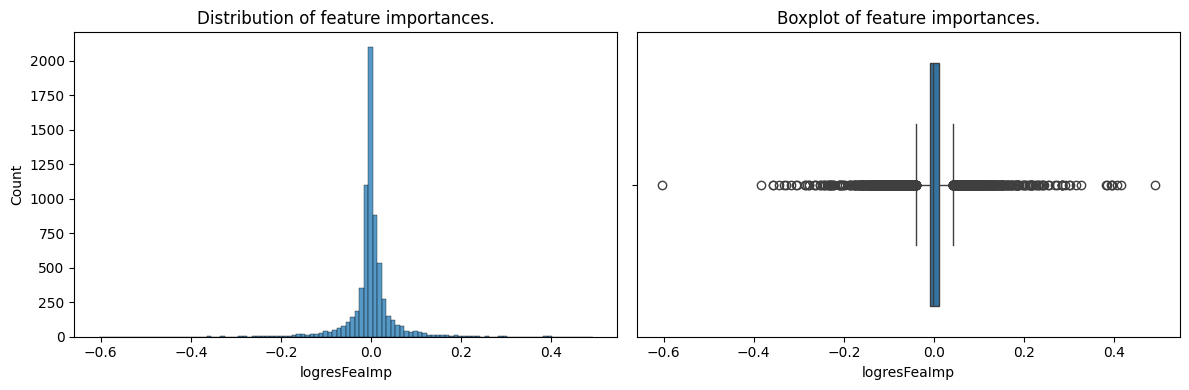

In [320]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4), sharey=False)
sns.histplot(data=odf_temp['logresFeaImp'], binwidth=0.01, ax=ax[0])
sns.boxplot(data=odf_temp['logresFeaImp'], orient='h', showfliers=True, ax=ax[1])
ax[0].set_title('Distribution of feature importances.')
ax[1].set_title('Boxplot of feature importances.')
plt.tight_layout()
plt.show()

### LogRes Regulatization

In [321]:
%%time
acc_, f1_ = [],[]
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')
RANGE = np.arange(0.001,1.5,0.01)
for c_ in tqdm(RANGE):
    logresEN = LogisticRegression(random_state=SEED, penalty='elasticnet', C=c_, solver='saga', l1_ratio=0.5)
    logresEN.fit(xtrain, ytrain)
    
    ypred = logresEN.predict(xtest)
    
    rep_ = classification_report(ytest,ypred,output_dict=True, zero_division=0)
    acc_.append(rep_['accuracy'])
    f1_.append(rep_['macro avg']['f1-score'])
    
    

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)


100%|█████████████████████████████████████████| 150/150 [03:53<00:00,  1.56s/it]

CPU times: user 5min 57s, sys: 2min 24s, total: 8min 22s
Wall time: 3min 54s


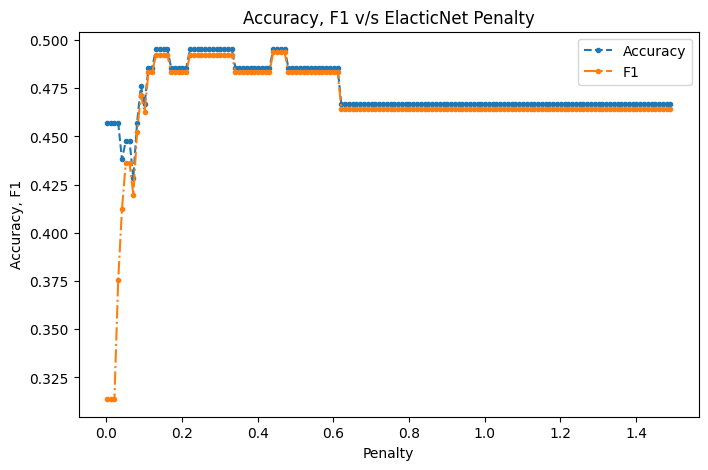

In [323]:
plt.figure(figsize=(8,5), dpi = 100)
plt.plot(RANGE, acc_, '.--', label='Accuracy')
plt.plot(RANGE, f1_, '.-.', label='F1')
plt.legend()
plt.title("Accuracy, F1 v/s ElacticNet Penalty")
plt.xlabel("Penalty")
plt.ylabel("Accuracy, F1")
plt.show()

## Support Vector Machines

In [324]:
from sklearn.svm import SVC

In [325]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')
svm = SVC(random_state=SEED)

svm.fit(xtrain, ytrain)

ypred = svm.predict(xtest)

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)
CPU times: user 395 ms, sys: 30.8 ms, total: 426 ms
Wall time: 478 ms


              precision    recall  f1-score   support

         low       0.44      0.07      0.12        57
        high       0.45      0.90      0.60        48

    accuracy                           0.45       105
   macro avg       0.45      0.48      0.36       105
weighted avg       0.45      0.45      0.34       105



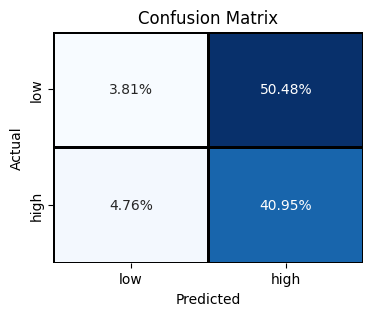

In [326]:
_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### KFold CV

In [327]:
xdata, ydata = genDataFnx(test_size=None)
svmK = SVC()

CV = 10
scores = cross_val_score(svmK, xdata, ydata, cv=5, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.65% accuracy with a standard deviation of 0.04 for 10 folds.


## Decision Tree

In [328]:
from sklearn.tree import DecisionTreeClassifier

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)
              precision    recall  f1-score   support

         low       0.65      0.54      0.59        57
        high       0.54      0.65      0.59        48

    accuracy                           0.59       105
   macro avg       0.59      0.59      0.59       105
weighted avg       0.60      0.59      0.59       105



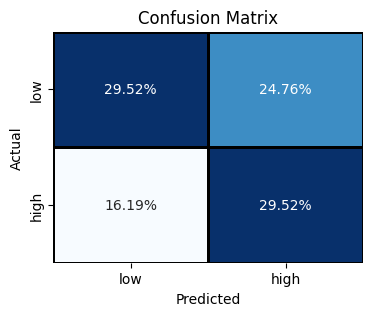

CPU times: user 405 ms, sys: 16 ms, total: 421 ms
Wall time: 392 ms


In [329]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')
dt = DecisionTreeClassifier()

dt.fit(xtrain, ytrain)
ypred = dt.predict(xtest)

_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### Feature Importance


In [330]:
feature_importance = dt.feature_importances_

In [331]:
feaimpCols = []
for fi, col in zip(feature_importance, mp_df.columns):
    if fi != 0:
        # print(f"Feature Importance of {col} : {fi}")
        feaimpCols.append(col)
print(len(feaimpCols))

35


Data Shape: (244, 35) : (105, 35) : (244,) : (105,)
              precision    recall  f1-score   support

         low       0.63      0.51      0.56        57
        high       0.53      0.65      0.58        48

    accuracy                           0.57       105
   macro avg       0.58      0.58      0.57       105
weighted avg       0.58      0.57      0.57       105



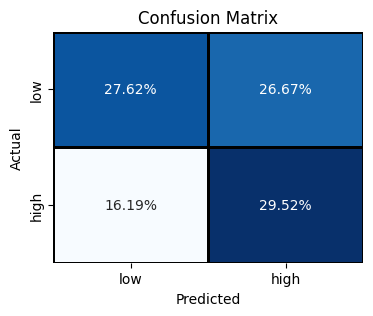

In [332]:
xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=feaimpCols, scale='standard')
dt = DecisionTreeClassifier()

dt.fit(xtrainE, ytrainE)
ypredE = dt.predict(xtestE)

_ = resultAnalysisFnx(ytestE, ypredE, target_names=TARGETNAMES)

### KFold CV

In [333]:
xdata, ydata = genDataFnx(scale=None, test_size=None)

dtK = DecisionTreeClassifier()

CV = 10
scores = cross_val_score(dtK, xdata, ydata, cv=CV, scoring='f1')
print(f"Average {scores.mean():.2f}% accuracy with a standard deviation of {scores.std():.2f} for {CV} folds.")

Average 0.49% accuracy with a standard deviation of 0.10 for 10 folds.


### DT - Level Wise

In [334]:
for i in range(1, outlierDf['level'].max()+1):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale='standard')
    
    dt = DecisionTreeClassifier()
    dt.fit(xtrainE, ytrainE)
    
    ypredE = dt.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    print(f"Number of Columns at level{i}: {len(colExp)} features with acc of {tt['accuracy']*100:.2f}%")

Data Shape: (244, 539) : (105, 539) : (244,) : (105,)
Number of Columns at level1: 539 features with acc of 51.43%
Data Shape: (244, 539) : (105, 539) : (244,) : (105,)
Number of Columns at level2: 539 features with acc of 55.24%
Data Shape: (244, 11) : (105, 11) : (244,) : (105,)
Number of Columns at level3: 11 features with acc of 48.57%
Data Shape: (244, 5345) : (105, 5345) : (244,) : (105,)
Number of Columns at level4: 5345 features with acc of 54.29%
Data Shape: (244, 305) : (105, 305) : (244,) : (105,)
Number of Columns at level5: 305 features with acc of 48.57%
Data Shape: (244, 96) : (105, 96) : (244,) : (105,)
Number of Columns at level6: 96 features with acc of 48.57%


### Grid Search

In [ ]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'class_weight': [None, 'balanced'],
    'random_state': [42]
}

dtGS = DecisionTreeClassifier()

clfdt = GridSearchCV(dtGS, params, n_jobs=-1)

clfdt.fit(xtrain, ytrain)

Data Shape: (244, 6835) : (105, 6835) : (244,) : (105,)


In [ ]:
# pd.DataFrame(clf.cv_results_)
clfdt.best_score_

In [ ]:
clfdt.best_params_

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale=None)
rf = RandomForestClassifier(max_depth=3)

rf.fit(xtrain, ytrain)
ypred = rf.predict(xtest)

_ = resultAnalysisFnx(ytest, ypred, target_names=TARGETNAMES)

### RF - Level Wise

In [ ]:
for i in range(1, outlierDf['level'].max()+1):
    colExp = outlierDf[outlierDf['level']==i]['feature'].values.tolist()
    
    xtrainE, xtestE, ytrainE, ytestE, _ = genDataFnx(columns=colExp, scale='standard')
    
    rf = DecisionTreeClassifier()
    rf.fit(xtrainE, ytrainE)
    
    ypredE = rf.predict(xtestE)
    tt = classification_report(ytestE,ypredE,output_dict=True, zero_division=0)
    print(f"Number of Columns at level{i}: {len(colExp)} features with acc of {tt['accuracy']*100:.2f}%")

### Grid Search

In [176]:
%%time
params = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 20],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'oob_score': [True, False],
    'warm_start': [True, False],
    'class_weight': [None, 'balanced'],
    'random_state': [42],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'n_jobs': [-1],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'max_samples': [None, 0.5, 0.8]
}


xtrain, xtest, ytrain, ytest, _ = genDataFnx(scale='standard')
rfGS = RandomForestClassifier()

clfrf = GridSearchCV(rfGS, params, n_jobs=-1)

# clfrf.fit(xtrain, ytrain)

Data Shape: (244, 1566) : (105, 1566) : (244,) : (105,)
CPU times: user 571 ms, sys: 556 ms, total: 1.13 s
Wall time: 1.13 s


In [175]:
clfrf.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

### Feature Importances

In [ ]:
feature_importance = rf.feature_importances_

feaimpCols = []
for fi, col in zip(feature_importance, mp_df.columns):
    if fi != 0:
        # print(f"Feature Importance of {col} : {fi}")
        feaimpCols.append(col)
print(len(feaimpCols))